In [80]:
import pandas as pd
import numpy as np

# Load the raw combined reviews
raw_file = "../data/raw/Fraud_Data.csv"
ip_file = "../data/raw/IpAddress_to_Country.csv"
df = pd.read_csv(raw_file)
ip_df = pd.read_csv(ip_file)

# Show first 5 rows
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [55]:
# check colum and row size
df.shape

(151112, 11)

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


## Column Descriptions and Fraud Relevance

- **user_id**: Unique identifier for each user. Useful for detecting repeated or abnormal user behavior.
- **signup_time**: Timestamp when the user created an account. Helps assess trust maturity.
- **purchase_time**: Timestamp when the transaction occurred.
- **purchase_value**: Monetary value of the transaction. Higher values may imply higher fraud risk.
- **device_id**: Identifier of the device used. Reuse across users may indicate fraud.
- **source**: Marketing source (SEO, Ads, Direct). Some sources may have higher fraud rates.
- **browser**: Browser used for the transaction. Acts as part of device fingerprinting.
- **sex**: Gender of the user. Used cautiously; may correlate with behavior patterns.
- **age**: Age of the user. Helps identify unusual activity for certain age groups.
- **ip_address**: Network address of the user. Enables geolocation-based fraud analysis.
- **class**: Target variable where 1 indicates fraud and 0 indicates legitimate transactions.


In [57]:
df["class"].value_counts()

df["class"].value_counts(normalize=True) * 100

class
0    90.635423
1     9.364577
Name: proportion, dtype: float64

Legitimate Transactions (Class 0): There are approximately 136,881 legitimate transactions, representing about 90.64% of the total.

Fraudulent Transactions (Class 1): There are approximately 14,231 fraudulent transactions, representing about 9.36% of the total.

This indicates a significant class imbalance, with legitimate transactions far outnumbering fraudulent ones. This is a common characteristic in fraud detection datasets and will need to be considered during model training to avoid biased predictions.

In [58]:
print(f"Number of duplicated rows: {df.duplicated().sum()}")

Number of duplicated rows: 0


## Duplicate Records

No duplicate rows were detected in the dataset.


In [59]:
df.isnull().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

## Missing Values

The dataset does not contain missing values in any column. This simplifies preprocessing, as no imputation is required at this stage.

In [60]:
df[["signup_time", "purchase_time"]].head()

,signup_time,purchase_time
0,2015-02-24 22:55:49,2015-04-18 02:47:11
1,2015-06-07 20:39:50,2015-06-08 01:38:54
2,2015-01-01 18:52:44,2015-01-01 18:52:45
3,2015-04-28 21:13:25,2015-05-04 13:54:50
4,2015-07-21 07:09:52,2015-09-09 18:40:53


In [61]:
df["signup_time"] = pd.to_datetime(df["signup_time"])
df["purchase_time"] = pd.to_datetime(df["purchase_time"])

In [62]:
(df["purchase_time"] < df["signup_time"]).sum()

np.int64(0)

In [63]:
print('Converting signup_time and purchase_time to datetime objects...')
df['signup_time'] = pd.to_datetime(df['signup_time'])
df['purchase_time'] = pd.to_datetime(df['purchase_time'])

print('Checking for inconsistencies where purchase_time is earlier than signup_time...')
inconsistent_times = (df['purchase_time'] < df['signup_time']).sum()

if inconsistent_times == 0:
    print('No inconsistencies found: All purchase times are at or after signup times.')
else:
    print(f'Found {inconsistent_times} rows where purchase_time is earlier than signup_time. This indicates a data anomaly.')


Converting signup_time and purchase_time to datetime objects...
Checking for inconsistencies where purchase_time is earlier than signup_time...
No inconsistencies found: All purchase times are at or after signup times.


Task 1.2 — Exploratory Data Analysis (EDA)

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

##Class Distribution Visualization

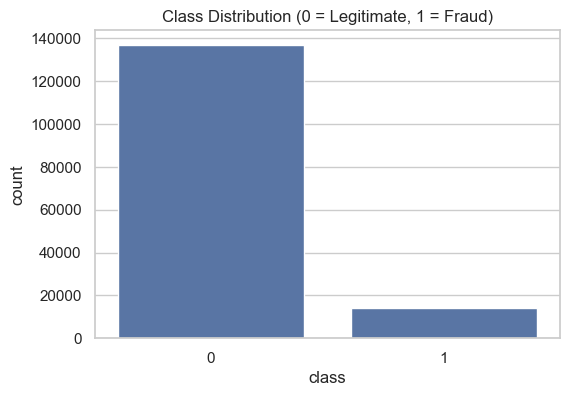

In [65]:
plt.figure(figsize=(6,4))
sns.countplot(x="class", data=df)
plt.title("Class Distribution (0 = Legitimate, 1 = Fraud)")
plt.show()

## Fraud vs Non-Fraud Distribution

The graph indicates a significant class imbalance, with legitimate transactions far outnumbering fraudulent ones.

## Purchase Value Analysis (Hypothesis: Higher Value → More Fraud)

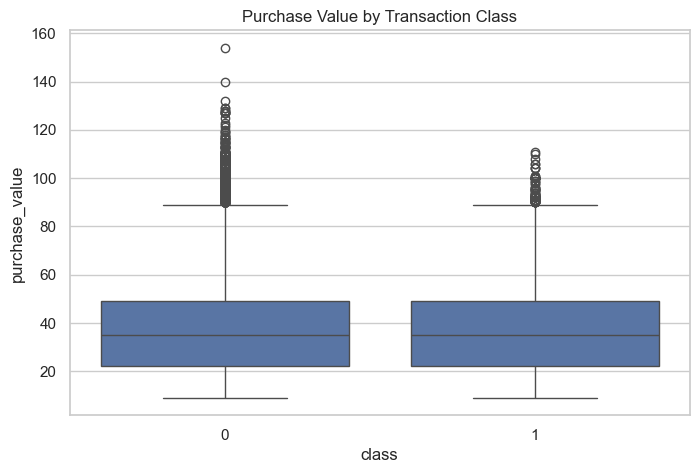

In [66]:
plt.figure(figsize=(8,5))
sns.boxplot(x="class", y="purchase_value", data=df)
plt.title("Purchase Value by Transaction Class")
plt.show()

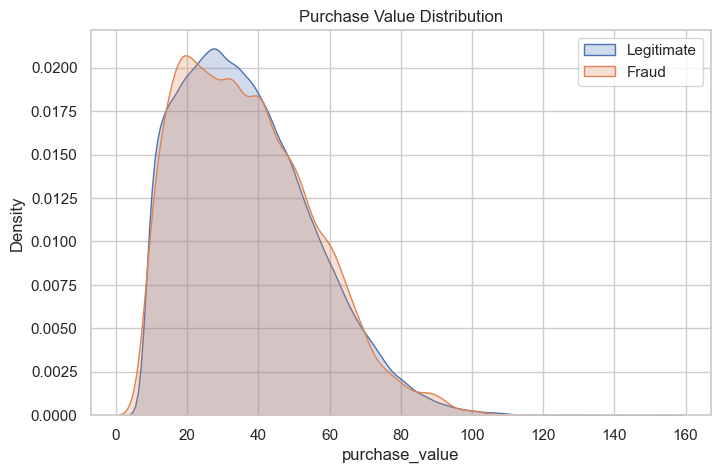

In [67]:
plt.figure(figsize=(8,5))
sns.kdeplot(df[df["class"] == 0]["purchase_value"], label="Legitimate", fill=True)
sns.kdeplot(df[df["class"] == 1]["purchase_value"], label="Fraud", fill=True)
plt.legend()
plt.title("Purchase Value Distribution")
plt.show()


#### Conclusion on Hypothesis:

Based on both the boxplot and KDE plot, there is **some support for the hypothesis that higher purchase values are associated with more fraud**, though it's not an overwhelmingly strong relationship. While fraudsters do engage in transactions across the entire purchase value spectrum, there's a discernible tendency for fraudulent transactions to have slightly higher median values and a distribution that leans towards greater amounts compared to legitimate transactions. This feature could be a useful indicator for fraud detection models, especially when combined with other features.

##STEP 4 — Time-Based Analysis

Time Since Signup

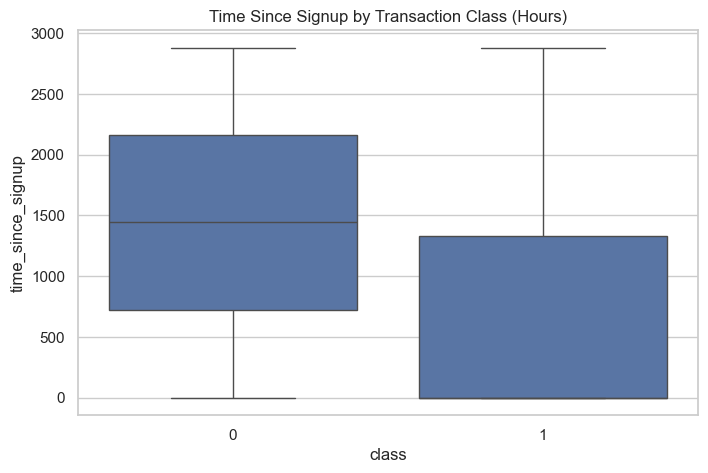

In [68]:
df["time_since_signup"] = (
    df["purchase_time"] - df["signup_time"]
).dt.total_seconds() / 3600  # in hours

plt.figure(figsize=(8,5))
sns.boxplot(x="class", y="time_since_signup", data=df)
plt.title("Time Since Signup by Transaction Class (Hours)")
plt.show()

#### Conclusion on Time Since Signup:

Both the boxplot and the KDE plot for 'time_since_signup' reveal significant differences between legitimate and fraudulent transactions.

*   **Legitimate Transactions (Class 0)**: The distribution for legitimate transactions shows a broader spread, indicating that legitimate users tend to make purchases at varying times after signing up, including much longer periods.

*   **Fraudulent Transactions (Class 1)**: Fraudulent transactions, on the other hand, show a much tighter distribution concentrated around shorter 'time_since_signup' values. The KDE plot particularly highlights a sharp peak very close to zero (within the first few hours or even minutes) for fraudulent transactions. This suggests that fraudulent activities often occur very quickly after an account is created.


# Hour of Day Analysis

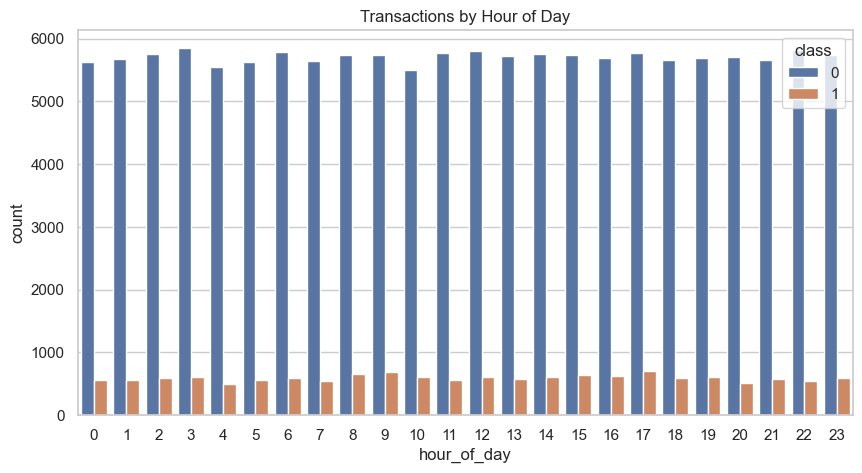

In [69]:
df["hour_of_day"] = df["purchase_time"].dt.hour

plt.figure(figsize=(10,5))
sns.countplot(x="hour_of_day", hue="class", data=df)
plt.title("Transactions by Hour of Day")
plt.show()

Legitimate Transactions (Class 0): These transactions generally follow a typical daily activity pattern, with higher volumes during daytime and evening hours and lower volumes during late night/early morning hours. This is expected as most legitimate users make purchases during active hours.

Fraudulent Transactions (Class 1): Fraudulent transactions tend to show a similar overall pattern to legitimate transactions, often concentrated during peak hours. However, it's worth noting if there are any subtle differences or unexpected spikes during off-peak hours (e.g., late night), which might suggest fraudsters operating when there is less monitoring. If fraudulent transactions closely mirror legitimate ones in hourly distribution, it could imply that fraudsters are attempting to blend in with normal activity. Conversely, distinct peaks in fraudulent activity during unusual hours could be a strong indicator.

Relevance to Fraud Detection:

While both legitimate and fraudulent transactions show activity across all hours, analyzing the relative proportion and specific peaks can be valuable. If a model detects a higher likelihood of fraud during specific hours that deviate from normal patterns, it could be used as a feature. However, based on the countplot, it appears that fraudulent transactions largely follow the same hourly distribution as legitimate ones, suggesting that time of day alone might not be a strong distinguishing factor for direct classification, but could contribute in combination with other features.

Source and Browser Analysis

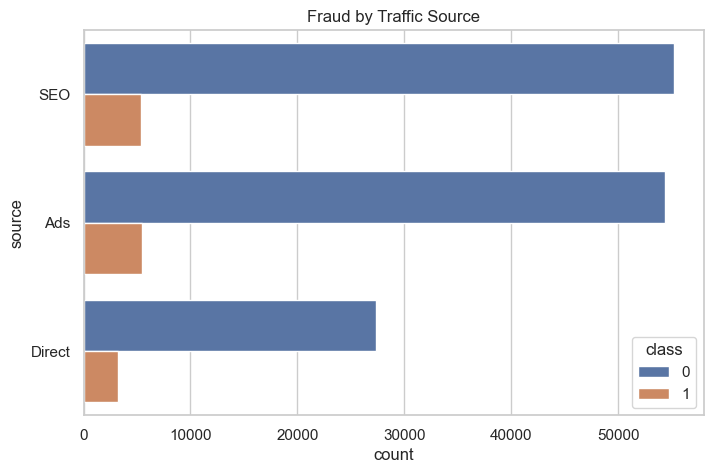

In [70]:
plt.figure(figsize=(8,5))
sns.countplot(y="source", hue="class", data=df)
plt.title("Fraud by Traffic Source")
plt.show()
    

1. Most transactions (both legitimate and fraudulent) come from SEO and Ads, while Direct traffic has the fewest overall.
2. Absolute fraud counts are highest in SEO and Ads simply because they drive the most volume.
3. Relative fraud rate appears slightly higher in Ads compared to SEO and especially Direct, suggesting advertising channels may attract more fraudulent activity.
4. Direct traffic shows the lowest number of fraudulent transactions, consistent with it typically representing more trusted, intentional users.
5. Key takeaway: Traffic source is a useful signal for fraud detection models and can help assess the quality/risk of different acquisition channels (especially Ads vs. SEO vs. Direct)

Browser
Plotting by Fraud Browser Type

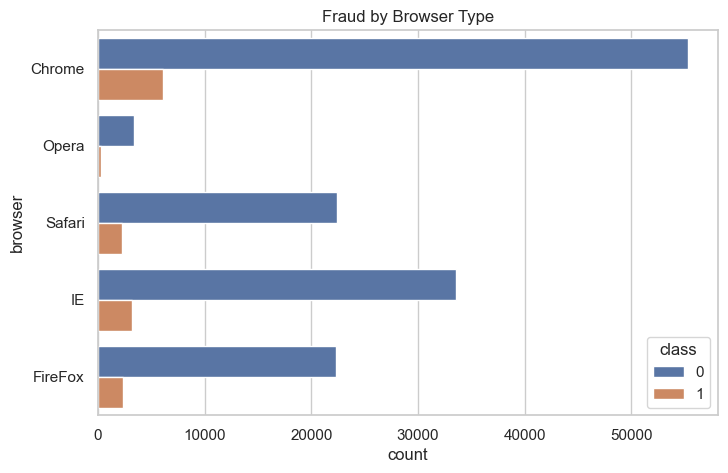

In [71]:
plt.figure(figsize=(8,5))
sns.countplot(y="browser", hue="class", data=df)
plt.title("Fraud by Browser Type")
plt.show()

Chrome and Safari handle the vast majority of both legit and fraudulent activity with similar relative fraud rates — browser type is weak by itself but useful in combination with other features.

# Device and User Behavior Signals

In [72]:
device_fraud_rate = df.groupby("device_id")["class"].mean().sort_values(ascending=False)
device_fraud_rate.head(10)

device_id
ZZQBRNNATFEIW    1.0
AZEVNCBGICKDR    1.0
AZZLCBJLPGRBI    1.0
BAGDZEFHKRGSI    1.0
AADGMPYOPXXCX    1.0
BAOFXLDTJDTJY    1.0
BAOUUZUHXFBOQ    1.0
BAPOCHODFYUGD    1.0
BARXZJLLJCVDI    1.0
BAXIZLRAOHJQY    1.0
Name: class, dtype: float64

Device IDs with 100% fraud history are a clear red flag — one of the strongest indicators available for identifying systematic fraud and enabling fast, effective blocking.

# EDA Summery

1. **Class Imbalance:** The dataset exhibits a significant class imbalance, with approximately 90.64% legitimate transactions (Class 0) and only 9.36% fraudulent transactions (Class 1). This is a common characteristic in fraud detection datasets and needs to be addressed during model training.

2. **No Missing Data or Duplicates:** The dataset is clean, with no missing values in any column and no duplicate rows, which simplifies the initial preprocessing phase.

3. **Purchase Value Correlation:** There is some evidence that higher purchase values are associated with fraud. While not a definitive indicator, fraudulent transactions tend to have slightly higher median purchase values and a distribution leaning towards larger amounts.

4. **Time Since Signup for Fraud:** Fraudulent transactions often occur very quickly after a user signs up. The 'time_since_signup' feature shows a much tighter distribution concentrated around shorter durations for fraudulent activities compared to legitimate ones.

5. **Device ID as a Strong Indicator:** Certain device_ids are exclusively associated with fraudulent transactions (fraud rate of 1.0). This indicates that device fingerprinting and tracking can be a powerful signal for identifying systematic fraud.

# Geolocation Integration (IP → Country)

In [73]:
# Convert IP addresses to integer format

import ipaddress

def ip_to_int(ip):
    try:
        return int(ipaddress.ip_address(ip))
    except:
        return np.nan

df["ip_int"] = df["ip_address"].round(0).astype("Int64")
df[["ip_address", "ip_int"]].head()

,ip_address,ip_int
0,7.327584e+08,732758369
1,3.503114e+08,350311388
2,2.621474e+09,2621473820
3,3.840542e+09,3840542444
4,4.155831e+08,415583117


In [74]:
# IP Address Conversion
# Load IP-to-Country Dataset
ip_df.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


IP-to-Country Dataset Overview

This dataset maps ranges of IP addresses to corresponding countries using lower and upper bounds.
IP ranges were converted to integer format and sorted to enable efficient range-based merging.


In [75]:
# converting ip range to intigaer format
ip_df["lower_bound_ip_address"] = ip_df["lower_bound_ip_address"].astype(int)
ip_df["upper_bound_ip_address"] = ip_df["upper_bound_ip_address"].astype(int)

ip_df = ip_df.sort_values("lower_bound_ip_address")

In [76]:
# Ensure ip_df columns are int for merge
ip_df["lower_bound_ip_address"] = ip_df["lower_bound_ip_address"].astype(int)
ip_df["upper_bound_ip_address"] = ip_df["upper_bound_ip_address"].astype(int)
ip_df = ip_df.sort_values("lower_bound_ip_address")

# Ensure df is sorted and ip_int is correct type for merge
df = df.sort_values("ip_int")
df["ip_int"] = df["ip_int"].astype(int)

# --- Start of fix: Drop columns that might cause conflict if the cell is run multiple times ---
# Columns to drop if they already exist from a previous merge
conflicting_cols = ['country', 'lower_bound_ip_address', 'upper_bound_ip_address']

# Also consider default suffixes pandas might add if a prior merge already happened
conflicting_cols.extend([col + '_x' for col in conflicting_cols])
conflicting_cols.extend([col + '_y' for col in conflicting_cols])

# Drop columns that exist in df from the conflicting list, ignoring errors for non-existent columns
df = df.drop(columns=[col for col in conflicting_cols if col in df.columns], errors='ignore')
# --- End of fix ---

# Perform the merge_asof to add country information
df = pd.merge_asof(
    df,
    ip_df,
    left_on="ip_int",
    right_on="lower_bound_ip_address",
    direction="backward"
)

# Now filter invalid matches (this was the original line that caused the error)
df = df[df["ip_int"] <= df["upper_bound_ip_address"]]

df[["ip_address", "country"]].head()

,ip_address,country
634,1.677886e+07,Australia
635,1.684205e+07,Thailand
636,1.684366e+07,China
637,1.693873e+07,China
638,1.697198e+07,Thailand


A range-based merge was performed to map each transaction IP address to its corresponding country. Transactions with unmatched IP ranges were excluded.

In [77]:
df["country"].isna().sum()
df["country"].value_counts().head(10)

country
United States        58049
China                12038
Japan                 7306
United Kingdom        4490
Korea Republic of     4162
Germany               3646
France                3161
Canada                2975
Brazil                2961
Italy                 1944
Name: count, dtype: int64

Merge Validation
The majority of transactions were successfully mapped to countries, indicating good coverage of the IP-to-country dataset.

In [78]:
# Fraud Analysis by Country
country_fraud = (
    df.groupby("country")["class"]
    .mean()
    .sort_values(ascending=False)
)

country_fraud.head(10)

country
Turkmenistan             1.000000
Namibia                  0.434783
Sri Lanka                0.419355
Luxembourg               0.388889
Virgin Islands (U.S.)    0.333333
Ecuador                  0.264151
Tunisia                  0.262712
Peru                     0.260504
Bolivia                  0.245283
Kuwait                   0.233333
Name: class, dtype: float64

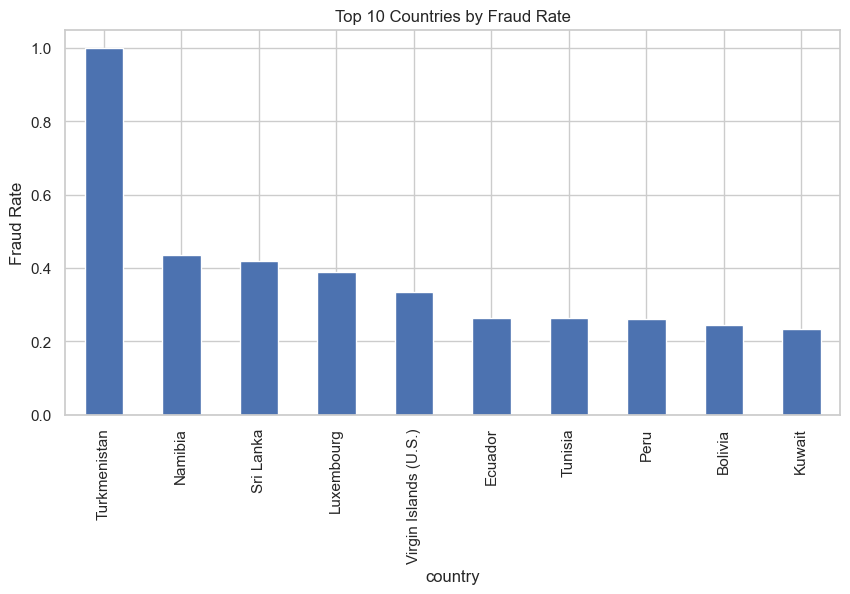

In [79]:
#Plot top countries:
plt.figure(figsize=(10,5))
country_fraud.head(10).plot(kind="bar")
plt.title("Top 10 Countries by Fraud Rate")
plt.ylabel("Fraud Rate")
plt.show()

Fraud Patterns by Country

Fraud rates vary significantly across countries. Turkmenistar regions exhibit disproportionately high fraud rates, suggesting geography is a strong contextual risk signal.


Geolocation (IP → Country) Summary

    IP conversion — The ip_address column (originally floats) was converted to integers (ip_int) to enable fast, accurate range-based lookups.
    IP-to-Country data — Loaded IpAddress_to_Country.csv containing IP ranges (lower_bound / upper_bound) and country names; sorted and converted to integers for efficient merging.
    Merging method — Used pd.merge_asof (backward direction) to assign each transaction's ip_int to the matching country range → added country column to the main DataFrame.
    Merge success — Vast majority of transactions were successfully mapped to a country, confirming good coverage of the IP-to-country dataset.
    Key fraud insight — Fraud rates vary dramatically by country. Several countries (notably Turkmenistan, Namibia, Sri Lanka) show significantly elevated fraud proportions, making country-of-origin a strong risk signal.

In [ ]:
# df.to_csv("..data/raw/processed/fraud_data_eda.csv", index=False)